In [1]:
import pickle
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

import matplotlib.pyplot as plot

In [2]:
def loadConfig():    
    with open('./light_config.yaml', "r") as ymlfile: #hulk, slowloris; GE, heartbleed, slowhttp
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fp_count = 0 # add
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList: # add
            fp_count = fp_count + 1 # add
        if IP + IPD in agt_attacks:
            tp_count = tp_count + 1            
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(fp_count/numNormal)
            truepos.append(tp_count / len(agt_attacks)) #len(agt_attacks)) # add
            
    return falsepositives, truepos

def calc_eval(fpr, tpr, agt_norm, agt_attk):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_norm)+len(agt_attk) #len(userScoreP)
    TotalN = len(agt_norm)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP+TP) #(FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)


In [4]:
def plotAndSaveGraph(P, PQ_online, PQ_offline, iter_one, iter_offline, config, plt=False, metric=None):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
#     ax.plot(percentages, P, linewidth=2, linestyle=':', markersize=9, label = "N Only")
    ax.plot(percentages, PQ_online, linewidth=2, linestyle='--', markersize=9, label = "Enhanced N/D (ℓ=1)") #With Transfer")
    ax.plot(percentages, PQ_offline, linewidth=2, linestyle='-.', markersize=9, label = "N/D (ℓ=1)") #Without Transfer") 
    ax.plot(percentages, iter_one, linewidth=2, linestyle='--', marker='o', markersize=9, label = "Enhanced Iter. (ℓ=1)") #Without Transfer")
    ax.plot(percentages, iter_offline, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=1)") #(ℓ=∞)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=18)
    if plt:
        if metric == 'F_pos':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPos-Graph')
        if metric == 'F_neg':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FNeg-Graph')

### Test set

In [5]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=True) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=True) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=True) 

# userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
# userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=True)

# userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
# userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=True)

print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12263


In [6]:
len(userScoreP)

12263

In [7]:
sum(userScoreP['Source IP'] == '999.16.30.0')

10000

In [8]:
import matplotlib.pyplot as plt
# attacker='172.16.0.1'; victim='192.168.10.50' # original attacker
attacker='999.16.30.0'; victim='999.16.30.1' # mimic attacker

# def showscore(scoretype, scores):
#     fig = plt.figure(figsize=(7,5))
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == victim], bins=20, alpha=0.5, label='victim') 
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == attacker], bins=20, alpha=0.5, label='attcker')
#     plt.legend(loc='upper right')
#     plt.show()
def showscore(scoretype, scores):
    fig = plt.figure(figsize=(7,5))
    plt.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, alpha=0.5, label='victim') 
    plt.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, alpha=0.5, label='attcker')
    plt.legend(loc='upper right')
    plt.show()
    return fig

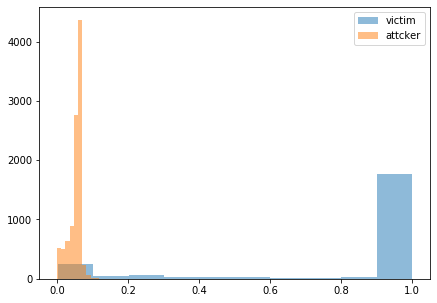

In [9]:
# add standardization
std_userScoreP = userScoreP
std_userScoreP['P'] = (std_userScoreP['P'] - std_userScoreP['P'].min(axis=0)) / (std_userScoreP['P'].max(axis=0) - std_userScoreP['P'].min(axis=0))

fig = showscore(userScoreP, 'P') # P scores

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_P_distr' + '.png')

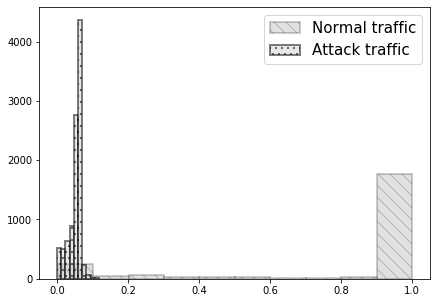

In [10]:
scoretype=userScoreP; scores='P'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper right',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_Nonly_distr' + '.png')

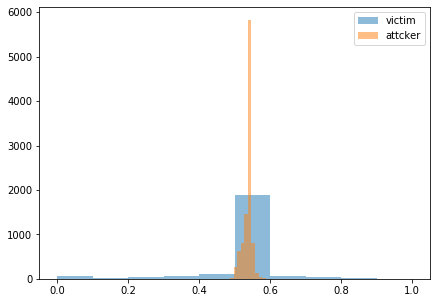

In [11]:
# add standardization
std_userScorePQ_online = userScorePQ_online
std_userScorePQ_online['PoverQ_online'] = (std_userScorePQ_online['PoverQ_online'] - std_userScorePQ_online['PoverQ_online'].min(axis=0)) / (std_userScorePQ_online['PoverQ_online'].max(axis=0) - std_userScorePQ_online['PoverQ_online'].min(axis=0))

fig = showscore(std_userScorePQ_online, 'PoverQ_online') # online Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQonline_distr' + '.png')

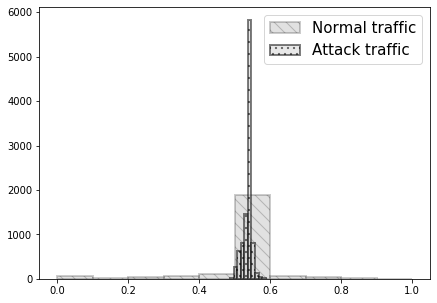

In [12]:
scoretype=std_userScorePQ_online; scores='PoverQ_online'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper right',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDonline_distr' + '.png')

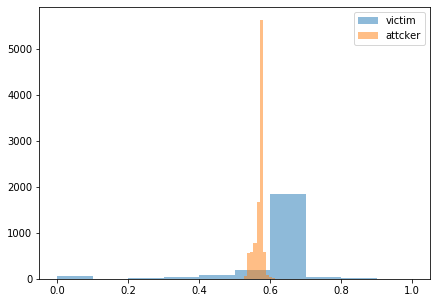

In [13]:
# add standardization
std_userScorePQ_offline = userScorePQ_offline
std_userScorePQ_offline['PoverQ_offline'] = (std_userScorePQ_offline['PoverQ_offline'] - std_userScorePQ_offline['PoverQ_offline'].min(axis=0)) / (std_userScorePQ_offline['PoverQ_offline'].max(axis=0) - std_userScorePQ_offline['PoverQ_offline'].min(axis=0))

fig = showscore(std_userScorePQ_offline, 'PoverQ_offline') # offline Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQoffline_distr' + '.png')

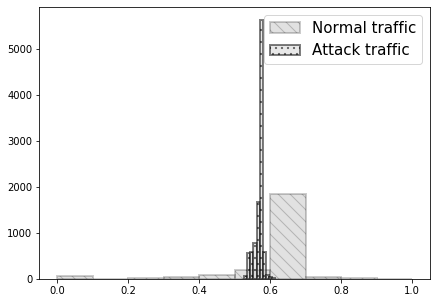

In [14]:
scoretype=std_userScorePQ_offline; scores='PoverQ_offline'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper right',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDoffline_distr' + '.png')

### Predicted P-only user scores

In [15]:
print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12263


In [16]:
agt_normals = []
agt_attacks = []
# attacker='172.16.0.1'; victim='192.168.10.50'
attacker='999.16.30.0'; victim='192.168.10.50'
print("Length of userScoreP: ", len(userScoreP))

for (IP, IPD, score) in list(userScoreP.itertuples(index=False, name=None)):
#     if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
#     if (IP != attacker and  IPD==victim) or IP == victim: 
    if IP == attacker or IP == victim:
        agt_attacks.append(IP+IPD)
    else:
        agt_normals.append(IP + IPD)
        

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent attacks: ", len(agt_attacks)/len(userScoreP))

Length of userScoreP:  12263
Length of Normal traffic:  2263
Length of true attacks:  10000
Percent attacks:  0.8154611432765229


In [35]:
''' Countermeasure!!!! '''
# Mimic results (FPR) Packet Len Cond

# (ℓ = ∞)
iter_classifier = [0,
 0.031816173221387536,
 0.052585064074237735,
 0.05788775961113566,
 0.058329650905877155,
 0.06142288996906761,
 0.062306672558550595,
 0.06319045514803358,
 0.06539991162174105,
 0.06937693327441449,
 1.0]

# (ℓ = 1)
iter_classifier_one = [0,
 0.0,
 0.0008837825894829872,
 0.003977021652673442,
 0.022978347326557666,
 0.040653999116217414,
 0.9743703049049933,
 0.9995581087052585,
 1.0,
 1.0,
 1.0]

In [36]:
''' Countermeasure!!!! '''
# Mimic results (FNR)
# (ℓ = ∞)
iter_offline_fnr = [0, 0.7654, 0.7875, 0.8018, 0.8146, 0.8274, 0.8414, 0.8582, 0.8881, 0.976, 1.0]

# (ℓ = 1)
iter_one_fnr = [0, 0.0, 0.0, 0.0016, 0.1253, 0.8097, 0.8731, 0.9981, 1.0, 1.0, 1.0]

In [37]:
graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
# graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
# graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

In [45]:
''' No countermeasure!!!!! '''

atkFPR_PQonline = [0, 0.127706584180292, 0.13300927971719, 0.135660627485639, 0.136986301369863, 0.137428192664605, 0.137428192664605, 0.13919575784357, 0.141405214317278, 0.458241272646929, 1]

atkFPR_iter_one = [0,
 0.9770216526734423,
 0.9946973044631021,
 0.9951391957578436,
 0.9955810870525851,
 0.9955810870525851,
 0.9960229783473266,
 0.996464869642068,
 0.9977905435262925,
 0.999116217410517,
 1.0]

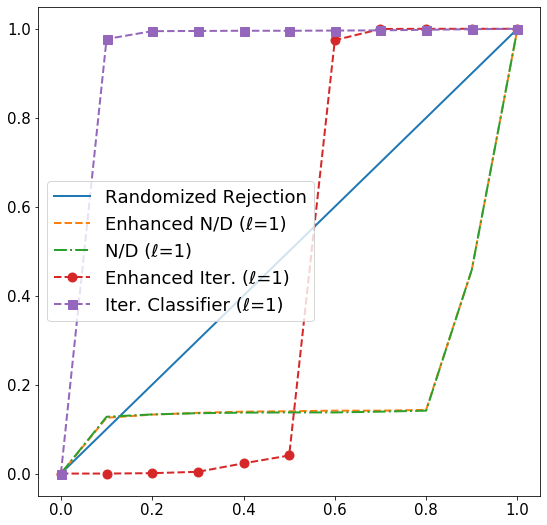

In [50]:
# plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, classifier_rejectthres, fp_classifier, 
#                  iter_classifier_one, iter_classifier, config) #, plt=True)

# plotAndSaveGraph(graphP, graphPQ_online, graphPQ_offline, 
#                  iter_classifier_one, iter_classifier, config) #, plt=True, metric='F_pos')
plotAndSaveGraph(graphP, graphPQ_online, atkFPR_PQonline, 
                 iter_classifier_one, atkFPR_iter_one, config, plt=True, metric='F_pos')

### Calculate False Negatives

In [22]:
def calculateFalseNegatives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsenegatives = [] #ADD
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fn_count = 0 #ADD
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agt_attacks: # ADD
            fn_count = fn_count + 1 # ADD
            
        index = index + 1
        if index in cutOff :
            falsenegatives.append(fn_count/len(agt_attacks)) #numNormal) # ADD
            
    return falsenegatives

In [23]:
# #Inverse User Scores
userScoreP_inv = userScoreP.sort_values(by = ['P'],ascending=False) # add
# userScoreP_inv
userScorePQ_online_inv = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=False) # add 
userScorePQ_offline_inv = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=False) 

print("Length of userScoreP: ", userScoreP_inv[:5]) #len(userScoreP))

Length of userScoreP:               Source IP        Dest IP    P
12262    202.1.175.252  71.126.222.64  1.0
9934   192.120.148.227  71.126.222.64  1.0
4086    51.173.229.255  71.126.222.64  1.0
4093     192.95.27.190  71.126.222.64  1.0
4097    51.173.229.255  71.126.222.64  1.0


In [24]:
graphP_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScoreP_inv, percentages, num)
graphPQ_online_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_online_inv, percentages, num)
graphPQ_offline_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_offline_inv, percentages, num)


graphP_fnr.insert(0, 0)
graphPQ_online_fnr.insert(0, 0)
graphPQ_offline_fnr.insert(0, 0)

In [25]:
print(graphP_fnr)
print(graphPQ_online_fnr)
print(graphPQ_offline_fnr)

[0, 0.0, 0.0338, 0.1516, 0.2729, 0.394, 0.5155, 0.6367, 0.7579, 0.879, 1.0]
[0, 0.0, 0.0514, 0.1736, 0.2963, 0.4186, 0.541, 0.6631, 0.7848, 0.9058, 1.0]
[0, 0.0005, 0.0503, 0.1725, 0.295, 0.4172, 0.5396, 0.6621, 0.7833, 0.9038, 1.0]


In [48]:
''' No countermeasure!!!!! '''
atkFNR_PQonline = [0, 0, 0.0509, 0.173, 0.2953, 0.4179, 0.5404, 0.6628, 0.7848, 0.9062, 1]

atkFNR_iter_one = [0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

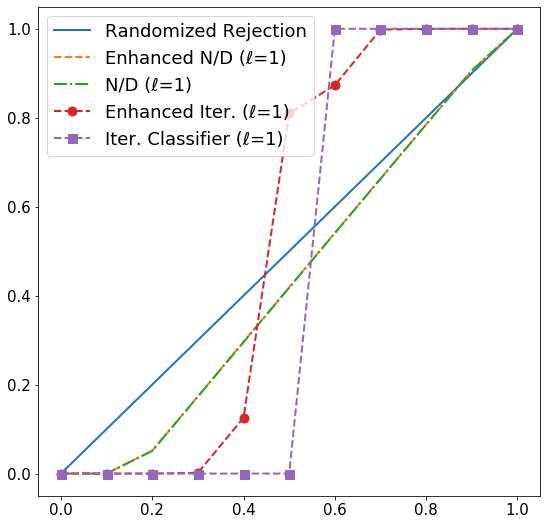

In [52]:
plotAndSaveGraph(graphP_fnr, graphPQ_online_fnr, atkFNR_PQonline, 
                 iter_one_fnr, atkFNR_iter_one, config) #, plt=True, metric='F_neg')

### Calculate evaluation metrics 

In [53]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr, agt_normals, agt_attacks)))
P_metrics = np.concatenate((P_metrics, np.reshape(graphP_fnr[1:], (-1, 1))), axis=1)

onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr, agt_normals, agt_attacks)))
onlinePQ_metrics = np.concatenate((onlinePQ_metrics, np.reshape(graphPQ_online_fnr[1:], (-1, 1))), axis=1)

offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr, agt_normals, agt_attacks)))
offlinePQ_metrics = np.concatenate((offlinePQ_metrics, np.reshape(graphPQ_offline_fnr[1:], (-1, 1))), axis=1)


P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P', 'FNR_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ', 'FNR_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ', 'FNR_offPQ'])

df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

In [54]:
# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_allPQresults.csv", index=False)

# Rows 3=0.4, 4=0.5, 5=0.6
df_FPresults#.iloc[4]

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,FNR_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,FNR_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ,FNR_offPQ
0,0.281986,0.013040,0.986960,0.1211,0.215730,0.0000,0.238278,0.231459,0.768541,0.0943,0.167988,0.0000,0.241540,0.215159,0.784841,0.0963,0.171551,0.0005
1,0.379516,0.012638,0.987362,0.2422,0.388983,0.0338,0.335644,0.122299,0.877701,0.2153,0.345780,0.0514,0.338090,0.116184,0.883816,0.2168,0.348189,0.0503
2,0.477208,0.012232,0.987768,0.3634,0.531325,0.1516,0.434152,0.083990,0.916010,0.3370,0.492726,0.1736,0.435782,0.081272,0.918728,0.3380,0.494188,0.1725
3,0.574819,0.012230,0.987770,0.4846,0.650208,0.2729,0.533230,0.064207,0.935793,0.4591,0.615994,0.2963,0.535513,0.061353,0.938647,0.4605,0.617872,0.2950
4,0.673000,0.011579,0.988421,0.6061,0.751426,0.3940,0.632879,0.051696,0.948304,0.5815,0.720927,0.4186,0.635163,0.049413,0.950587,0.5829,0.722663,0.4172
5,0.770529,0.011688,0.988312,0.7272,0.837885,0.5155,0.732366,0.043490,0.956510,0.7038,0.810923,0.5410,0.734486,0.041723,0.958277,0.7051,0.812421,0.5396
6,0.868303,0.011648,0.988352,0.8485,0.913102,0.6367,0.832423,0.037274,0.962726,0.8265,0.889427,0.6631,0.834217,0.035993,0.964007,0.8276,0.890611,0.6621
7,0.960450,0.015085,0.984915,0.9663,0.975519,0.7579,0.931746,0.033024,0.966976,0.9487,0.957751,0.7848,0.933540,0.031903,0.968097,0.9498,0.958861,0.7833
8,0.915437,0.093957,0.906043,1.0000,0.950706,0.8790,0.915437,0.093957,0.906043,1.0000,0.950706,0.9058,0.914621,0.094410,0.905590,0.9995,0.950231,0.9038
9,0.815461,0.184539,0.815461,1.0000,0.898352,1.0000,0.815461,0.184539,0.815461,1.0000,0.898352,1.0000,0.815461,0.184539,0.815461,1.0000,0.898352,1.0000


### Calculate evaluation metrics 

In [30]:
fpr=graphP; tpr=P_tpr
# fpr=graphPQ_online; tpr=onlinePQ_tpr
# fpr=graphPQ_offline; tpr=offlinePQ_tpr

In [31]:
tau = 5 #3=0.4, 4=0.5, 5=0.6
fpr = np.array(fpr[1:])
tpr = np.array(tpr)

Total = len(agt_normals)+len(agt_attacks) #len(userScoreP)
TotalN = len(agt_normals)
TotalP = Total-TotalN
FP = fpr*TotalN
TN = TotalN - FP
TP = tpr*TotalP
FN = TotalP-TP

print(Total, TotalN, TotalP, FP[tau], TN[tau], TP[tau], FN[tau])

12263 2263 10000 86.0 2177.0 7272.0 2728.0


In [32]:
Accr = (TP+TN) / (TP+TN+FP+FN)
FPR = FP / (FP + TN)
Prec = TP / (TP + FP)
Rec = TP / (TP + FN)
F1 = 2 * ((Prec*Rec) / (Prec+Rec))

print(Accr[tau], FPR[tau], Prec[tau], Rec[tau], F1[tau])

0.7705292342819865 0.03800265134776845 0.9883120413155749 0.7272 0.8378845489111648


In [33]:
graphP = np.array(graphP)
graphPQ= np.array(graphPQ_online)
graphPQTil= np.array(graphPQ_offline)

df_FPresults = pd.DataFrame({"P_FP":graphP[1:], "OnlineQ_FP":graphPQ[1:], "OfflineQ_FP":graphPQTil[1:], 
                             "Accr":Accr, "FPR":FPR, "Precision":Prec, 
                             "Recall":Rec, "F1_score":F1})

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_FPresults.csv", index=False)

In [34]:
df_FPresults

,P_FP,OnlineQ_FP,OfflineQ_FP,Accr,FPR,Precision,Recall,F1_score
0,0.007070,0.125497,0.116659,0.281986,0.007070,0.986960,0.1211,0.215730
1,0.013699,0.132567,0.125939,0.379516,0.013699,0.987362,0.2422,0.388983
2,0.019885,0.136544,0.132125,0.477208,0.019885,0.987768,0.3634,0.531325
3,0.026513,0.139196,0.133009,0.574819,0.026513,0.987770,0.4846,0.650208
4,0.031374,0.140080,0.133893,0.673000,0.031374,0.988421,0.6061,0.751426
5,0.038003,0.141405,0.135661,0.770529,0.038003,0.988312,0.7272,0.837885
6,0.044189,0.141405,0.136544,0.868303,0.044189,0.988352,0.8485,0.913102
7,0.065400,0.143173,0.138312,0.960450,0.065400,0.984915,0.9663,0.975519
8,0.458241,0.458241,0.460451,0.915437,0.458241,0.906043,1.0000,0.950706
9,1.000000,1.000000,1.000000,0.815461,1.000000,0.815461,1.0000,0.898352
